# Examples From 9.3.2

This notebook shows how we can use steepest descent methods with golden section search and discusses the concerns we might have with our methods so far.

The first cell just gets everything set up for our examples.

In [1]:
%%capture
from os import getcwd
while getcwd().split('\\')[-1] != 'optimisation':
    %cd ..
    pass


import numpy as np
from matplotlib import pyplot as plt

from src.gradient_descent import steepest_descent
from examples.examples_9_3_2 import obj_quadratic_r2, obj_quadratic_r2_jac, obj_nonquadratic_r2
from plotting.contour import contourf

## A Quadratic Problem in $\mathbb{R}^2$

Begining with a simple problem, we have $f(x) = \frac{1}{2}(x_1^2 + \gamma x_2^2)$. The condition number for the sublevel sets of this function is $\max(\gamma, \gamma^{-1})$, and we'll see that for good condition numbers our method works well from some points of view. The default value of $\gamma$ for this function is $2$. We can plot the sublevel sets to get an idea of what the surface looks like.

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

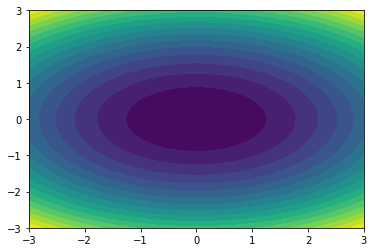

In [2]:
contourf(
    xlim=[-3, 3],
    ylim=[-3, 3],
    func = obj_quadratic_r2,
)

Let's run the steepest descent algorithm using golden section search. We will save the intermediate results using the `save_path` keyword so we can plot them.

In [3]:
initial_value = np.array([2, 2.5]).reshape(2, 1)
result = steepest_descent(
    func=obj_quadratic_r2,
    x0=initial_value,
    ls="golden-section",
    save_path=True,
)
result  # show our result

success: True
x*: 
[[ 4.68952236e-07]
 [-3.37160307e-07]]
jac(x*): 
[[ 4.68952236e-07]
 [-6.74320615e-07]]
niter: 10
nfev: 338
njev: 13
nhev: 0
info: None
soution path: available

We see that the algorithm reports success, within quite a low number of iterations. Since golden section search finds the minimum along each search direction it doesn't take many iterations to hone in on the global minimum. There is a penalty for this: the number of function evaluations is very high. Some of these come from the fact that we are evaluating the jacobian numericaly - so we should be able to reduce the number of function evaluations if we provide an explicit jacobian...

In [4]:
initial_value = np.array([2, 2.5]).reshape(2, 1)
result = steepest_descent(
    func=obj_quadratic_r2,
    jac=obj_quadratic_r2_jac,
    x0=initial_value,
    ls="golden-section",
    save_path=True,
)
result

success: True
x*: 
[[ 4.68952235e-07]
 [-3.37160308e-07]]
jac(x*): 
[[ 4.68952235e-07]
 [-6.74320616e-07]]
niter: 10
nfev: 286
njev: 13
nhev: 0
info: None
soution path: available

So, that does help a little, but not by much. Clearly the exact line search provided by golden section search comes at the expense of requiring many function evaluations. For completeness, let's plot our result:

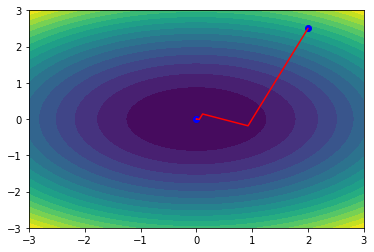

In [5]:
contourf(
    xlim=[-3, 3],
    ylim=[-3, 3],
    func = obj_quadratic_r2,
)
solution_path = np.hstack(result.solution_path)
solution_path = np.hstack([np.hstack(result.solution_path), result.x])

plt.plot(solution_path[0, :], solution_path[1, :], c='red')

plt.scatter(solution_path[0, 0], solution_path[1, 0], c='blue')  # start point
plt.scatter(solution_path[0, -1], solution_path[1, -1], c='blue')  # end point


What happens if our sublevel sets are poorly conditioned?

In [6]:
def obj_quadratic_r2_gamma100(x):  # this wrapper will call obj_quadratic_r2 with a new value of gamma
    return obj_quadratic_r2(x, gamma=30)

initial_value = np.array([2, 2.5]).reshape(2, 1)
result = steepest_descent(
    func=obj_quadratic_r2_gamma100,
    x0=initial_value,
    ls="golden-section",
    save_path=True,
)
result  # show our result

C:\Users\jeanp\Documents\Projects\Notebooks\optimisation\src\line_search.py:78: RuntimeWarning: invalid value encountered in true_divide
  't': np.average((xopt - x) / dx),  # x* = x + t*dx


success: False
x*: 
[[-4.48675867e-18]
 [ 6.28799626e-08]]
jac(x*): 
[[0.00000000e+00]
 [1.88639888e-06]]
niter: 1024
nfev: 17462
njev: 1026
nhev: 0
info: Maximum number of iterations exceeded.
soution path: available

Not only have our function evaluations gone through the roof; the function reports that it has failed to converge! In reality we actually have a result very close to the true minimum at $(0, 0)$, but the criterior being used to terminate is checking if $\Vert J(x) \Vert_2 < 10^{-6}$ and the ill-conditioning of the sublevel sets means that this check is failing.

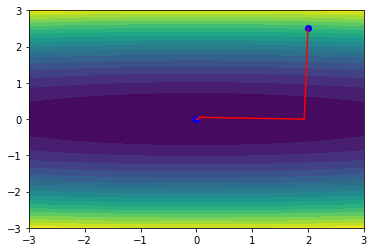

In [7]:
contourf(
    xlim=[-3, 3],
    ylim=[-3, 3],
    func = obj_quadratic_r2_gamma100,
)
solution_path = np.hstack(result.solution_path)
solution_path = np.hstack([np.hstack(result.solution_path), result.x])

plt.plot(solution_path[0, :], solution_path[1, :], c='red')

plt.scatter(solution_path[0, 0], solution_path[1, 0], c='blue')  # start point
plt.scatter(solution_path[0, -1], solution_path[1, -1], c='blue')  # end point

However, in reality the solver seems to hone in on the solution very quickly. Perhaps with a more intelligent convergence criterion we could salvage the situation?

## A Non-Quadratic Problem in $\mathbb{R}^2$

Let's turn to the next example: $f(x_1, x_2) = e^{x_1+3x_2-0.1} + e^{x_1-3x_2-0.1} + e^{-x_1-0.1}$. How does our method perform here?

success: True
x*: 
[[-3.46573603e-01]
 [-8.33193607e-08]]
jac(x*): 
[[-3.26749491e-08]
 [-9.59105860e-07]]
niter: 21
nfev: 660
njev: 24
nhev: 0
info: None
soution path: available

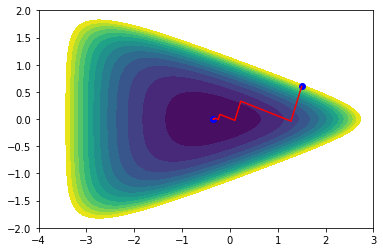

In [8]:
result = steepest_descent(
    func=obj_nonquadratic_r2,
    x0=np.array([1.5, 0.6]).reshape(2, 1),
    save_path=True,
)

contourf(
    xlim=[-4, 3],
    ylim=[-2, 2],
    func = obj_nonquadratic_r2,
    contours=range(2, 30, 2),  # matplotlib striggles to autoscale the contours, so we give them explicitly
)
solution_path = np.hstack(result.solution_path)
solution_path = np.hstack([np.hstack(result.solution_path), result.x])

plt.plot(solution_path[0, :], solution_path[1, :], c='red')

plt.scatter(solution_path[0, 0], solution_path[1, 0], c='blue')  # start point
plt.scatter(solution_path[0, -1], solution_path[1, -1], c='blue')  # end point
result

Quite reasonable. Again we have the problem of many function evaluations, but it does not take too many iterations to converge to the minimum at approximately $(-0.34, 0)$.

## Conclusion

So, exact line search with steepest descent works acceptably on well-conditioned problems in two varaibles but requires a high number of function evaluations. We have some obvious questions to answer now:

1. How well does steepest descent + exact line search work on well conditioned problems with many variables?
2. How does steepest descent + inexact line search compare in problems which are:
 1. well-conditioned, low dimensional?
 2. ill-conditioned, low dimensional?
 3. well-conditioned, high dimensional?

We will be looking into these questions further in future.